# 🏡 **House Price Prediction using Linear Regression**

Predict house prices based on various features using a Linear Regression model, offering insights into key factors that influence real estate values.

### 🛠️ **Automated Data Download and Extraction**

Using a custom function, download and extract the housing dataset. This method ensures that the data can be fetched and updated with ease, increasing process efficiency and scalability across many contexts.


In [293]:
import os
import tarfile
from six.moves import urllib
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"


In [294]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    with tarfile.open(tgz_path) as housing_tgz:
        housing_tgz.extractall(path=housing_path)
    print("Download and extraction complete.")


In [295]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    if not os.path.isfile(csv_path):
        print(f"{csv_path} does not exist. Fetching data...")
        fetch_housing_data()
    return pd.read_csv(csv_path)

In [296]:
housing = load_housing_data()
print(housing.head())

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  


In [297]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


All attributes are numerical, except the ocean_proximity field.

In [298]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


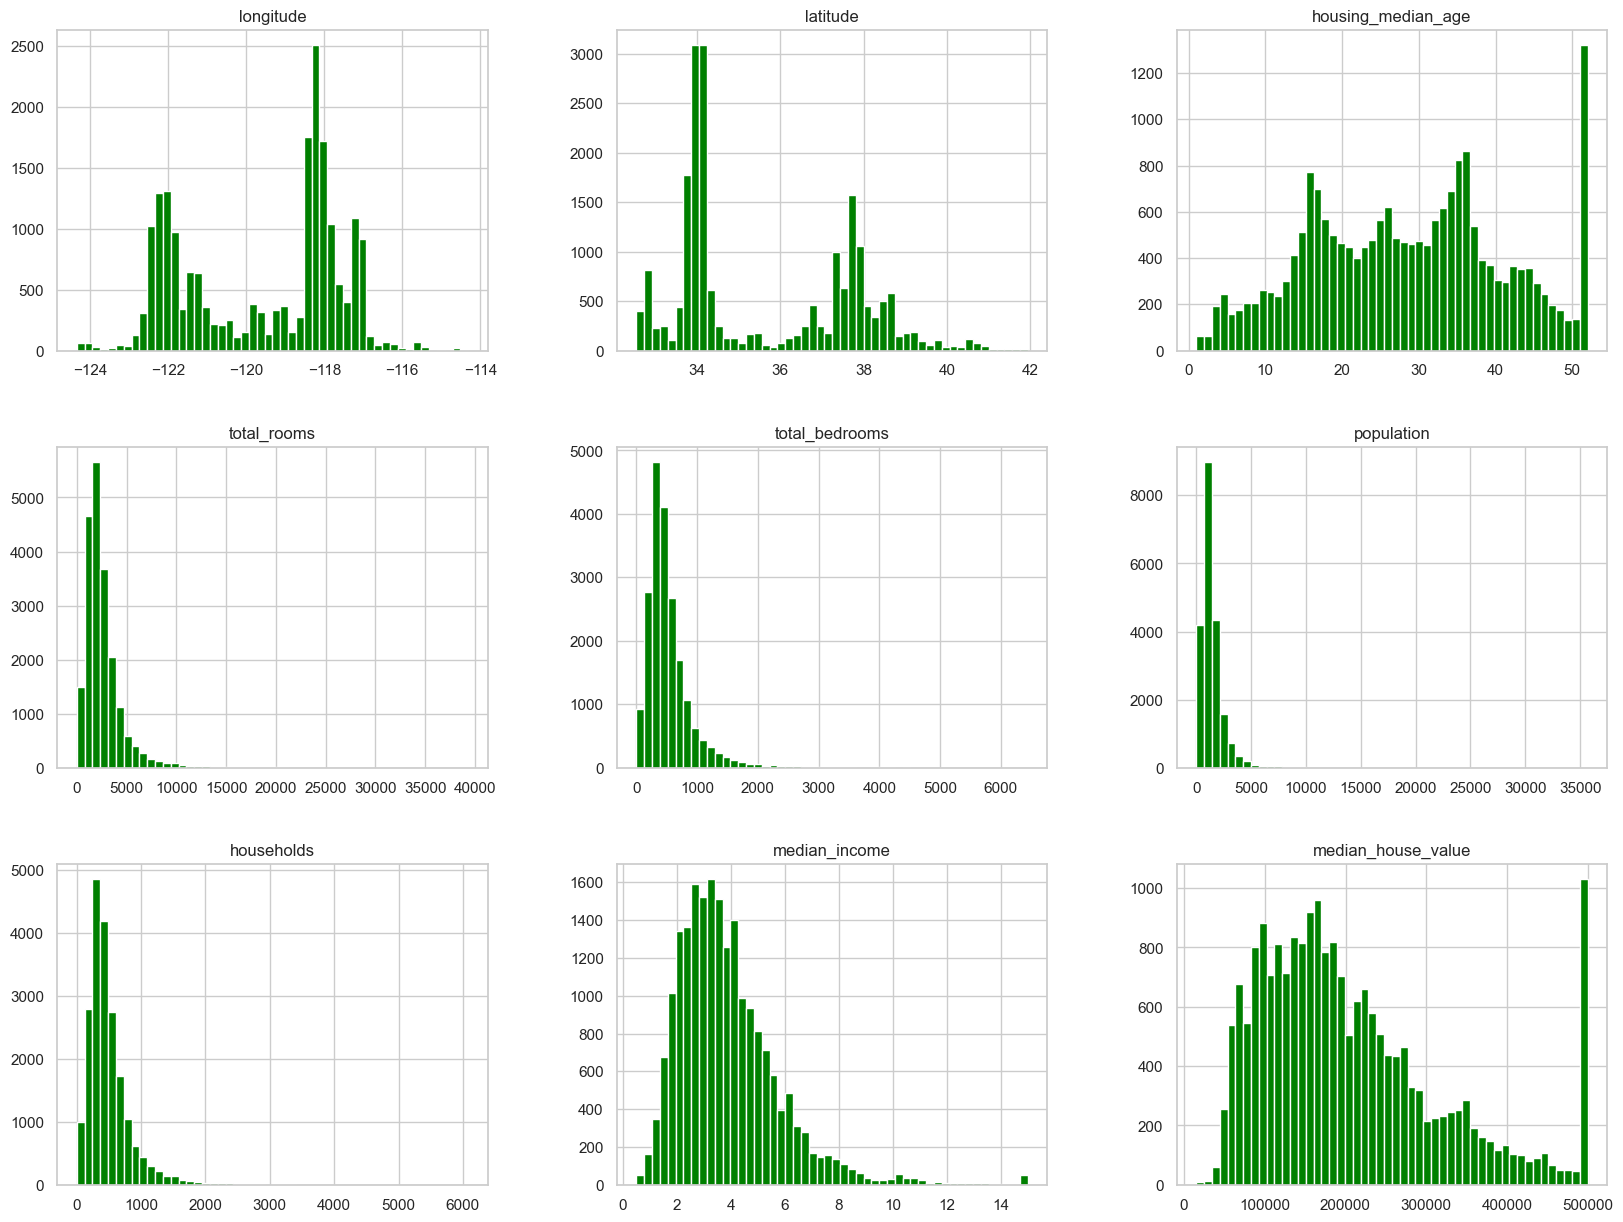

In [299]:
%matplotlib inline
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(20,15), color='green')  # You can change 'skyblue' to any color you prefer
plt.show()


# Data Insights

1. **Median Income**: This attribute is scaled and capped. Values are in tens of thousands of dollars (e.g., 3 means $30,000). It is infered that the scaling and capping is used in the data processing.

2. **Median Age & House Value**: Both are capped. The target attribute (median house value) being capped might limit the model's predictions. Verify if precise predictions beyond $500,000 are needed:
   - **Note**: Exclude capped districts from the training and test sets.

3. **Feature Scaling**: Attributes have different scales, which affects model performance.

4. **Distribution**: Histograms show tail-heavy distributions. This can hinder pattern detection in some models. We'll have to explore transformations to achieve more balanced distributions.


# 📊 Creating a Train and Test Set

In [300]:
import numpy as np
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [301]:
train_set, test_set = split_train_test(housing, 0.2)
len(train_set)


16512

In [302]:
len(test_set)

4128

In [303]:
from zlib import crc32
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32
def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [304]:
housing_with_id = housing.reset_index() # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [305]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [306]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [307]:
housing["income_cat"] = pd.cut(housing["median_income"],
bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
labels=[1, 2, 3, 4, 5])

<Axes: >

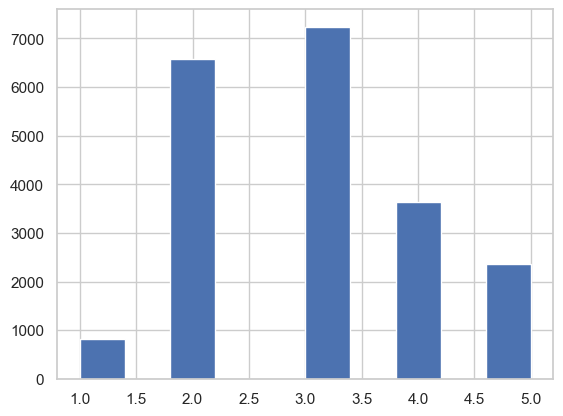

In [308]:
housing["income_cat"].hist()

# 📊 Stratified Sampling Based on Income Category

Stratified sampling ensures that each income category is proportionally represented in both training and test sets. 



In [309]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [310]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

 As you can see, the test set generated using stratified sampling has income category proportions almost identical to those in the full dataset, whereas the test set generated using purely random sampling is quite skewed.

Hence remove the `income_cat` attribute so the data is back to its original state:



In [311]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# 🔍 Exploratory Data Analysis (EDA)

Exploratory Data Analysis is a crucial step to understand the dataset and uncover insights.


In [312]:
housing = strat_train_set.copy()

<Axes: xlabel='longitude', ylabel='latitude'>

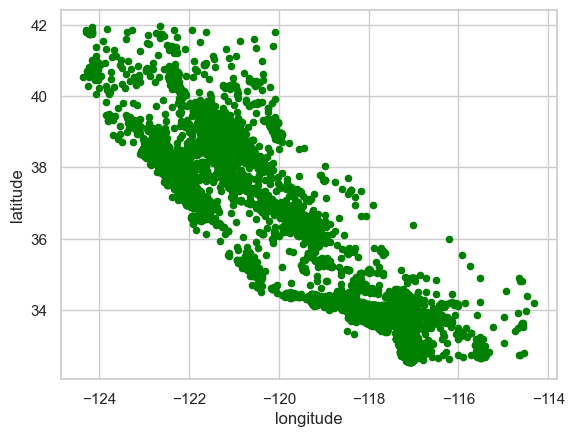

In [313]:
housing.plot(kind="scatter", x="longitude", y="latitude",color="green")

<Axes: xlabel='longitude', ylabel='latitude'>

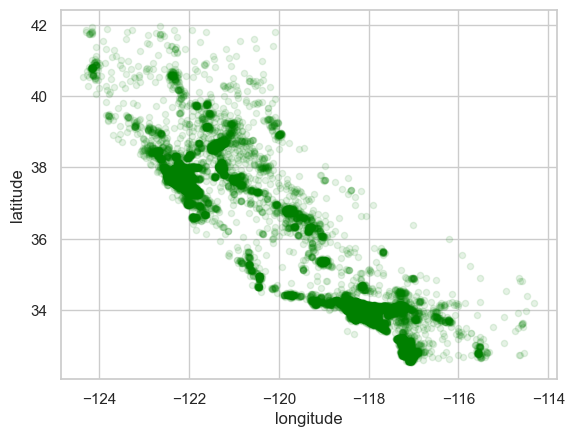

In [314]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1,color="green")

Setting the `alpha` option to `0.1` makes it much easier to visualize the places where there is a high density of data points. The radius of each circle represents the district’s population, and the color represents the price.


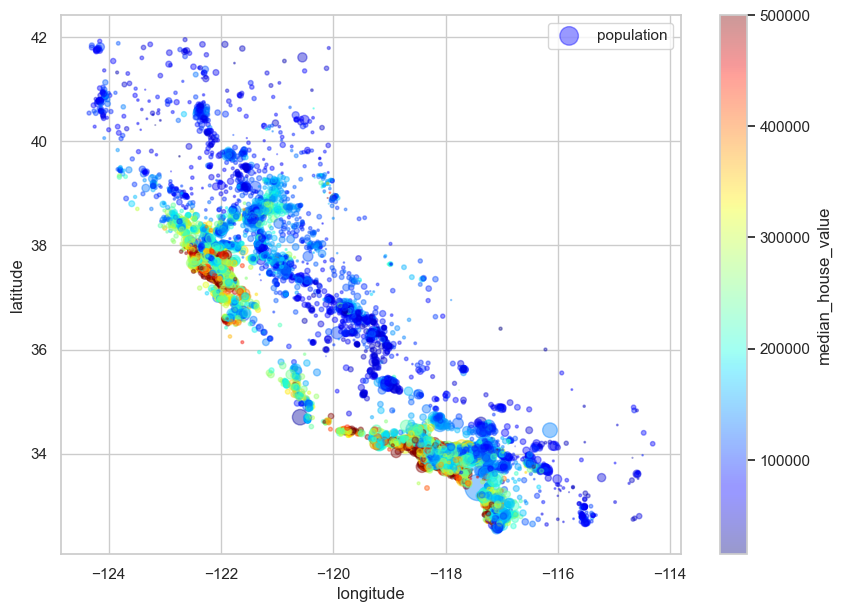

In [315]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
s=housing["population"]/100, label="population", figsize=(10,7),
c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

This graph shows that housing prices are strongly influenced by location (e.g., proximity to the ocean) and population density. It suggests using a clustering algorithm to identify main clusters and create features based on proximity to these clusters. 


# 🔗 Correlation Matrix

A correlation matrix is a table showing correlation coefficients between variables. Each cell in the matrix displays the correlation between two variables, with values ranging from -1 to 1:
- **1** indicates a perfect positive correlation.
- **-1** indicates a perfect negative correlation.
- **0** indicates no correlation.



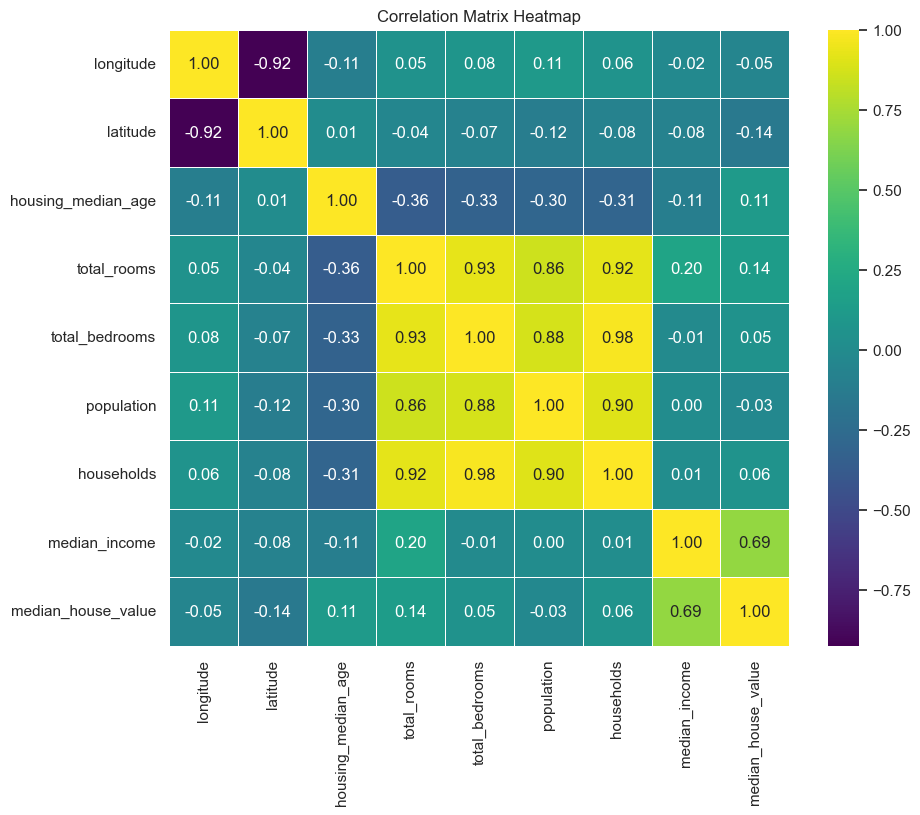

In [316]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = housing.select_dtypes(include=[np.number]).corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()



In [317]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

# 📊 Checking Correlation with Scatter Matrix

To check for correlation between attributes,  Pandas’ `scatter_matrix` can also be function. This function plots every numerical attribute against every other numerical attribute. Given that there are 11 numerical attributes, this would result in (11 x 2 = 121) plots, which can be overwhelming and may not fit on a single page.

Instead, focus on a subset of promising attributes that show the strongest correlation with the median housing value. This approach will make your analysis more manageable and insightful.


array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

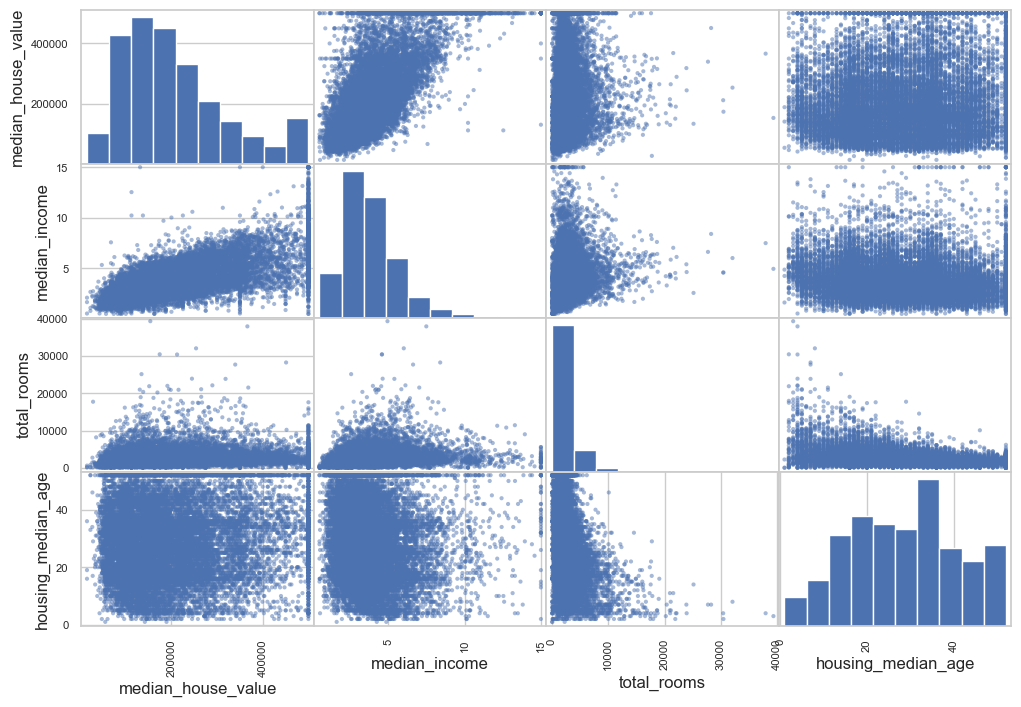

In [318]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms",
"housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8),alpha=0.5)

# 🧩 Observations from the Scatter Matrix

1. **Strong Correlation**: The scatter matrix clearly shows a strong upward trend in correlation, with data points tightly clustered and less dispersed.

2. **Price Cap Visibility**: The $500,000 price cap is evident as a horizontal line in the plot. 

3. **Additional Patterns**: Other horizontal lines are visible:
   - Around $450,000
   - Around $350,000
   - Around $280,000
   - A few more below these levels

These patterns suggest potential data quirks. Consider removing the districts corresponding to these anomalies to prevent your algorithms from learning these quirks.



<Axes: xlabel='median_income', ylabel='median_house_value'>

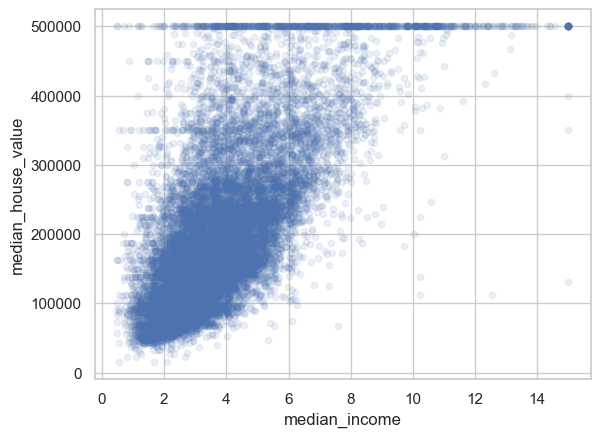

In [249]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
alpha=0.1)

# 🛠️ Data Preprocessing

Data preprocessing involves cleaning and transforming raw data, including handling missing values, scaling features, encoding categorical variables, and dealing with outliers. This ensures that the data is suitable for machine learning models and improves their performance.


# 🧪 Experimenting with Attribute Combinations

Before finalizing your data for machine learning, explore various attribute combinations to create more meaningful features. For instance, use ratios like rooms per household and population per household to capture more useful insights than individual attributes alone.


In [250]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [251]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

# 🧹 Data Cleaning

- **Remove Corresponding Districts**: Eliminate rows with problematic or incorrect data.
- **Drop the Whole Attribute**: Remove columns that are irrelevant or redundant.
- **Impute Missing Values**: Replace missing values with a specific value such as zero, the mean, or the median.


In [252]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [253]:
housing.dropna(subset=["total_bedrooms"])


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN
...,...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900,<1H OCEAN
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139,INLAND
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797,<1H OCEAN
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964,<1H OCEAN


Using `SimpleImputer` from Scikit-Learn, replace missing values with the median of each attribute. First, fit the imputer on numerical data, then transform the dataset to fill missing values with the computed medians, and optionally convert the result back to a Pandas DataFrame.


In [254]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [255]:
housing_num = housing.drop("ocean_proximity", axis=1)

In [256]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [257]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [258]:
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [259]:
X = imputer.transform(housing_num)

In [260]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

# 📝 Handling Text and Categorical Attributes

Handling text and categorical attributes involves encoding them into numerical formats that machine learning models can process. Use **label encoding** for ordinal data and **one-hot encoding** for nominal data. 🔢


In [261]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [262]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

In [263]:
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [264]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [265]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [266]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [267]:
cat_encoder.categories

'auto'

# 🛠️ Custom Transformers

To create custom transformers in Scikit-Learn, define a class with `fit()`, `transform()`, and optionally `fit_transform()` methods. Inherit from `TransformerMixin` for `fit_transform()` and `BaseEstimator` for `get_params()` and `set_params()` to integrate seamlessly with Scikit-Learn pipelines and hyperparameter tuning. 🔄


In [268]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

# Indices of the columns
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):  # no *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self  # nothing else to do

    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]


attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)


# 🔧 Feature Scaling and Transformation Pipelines

Create a Scikit-Learn pipeline to streamline data preprocessing by chaining steps like imputation, feature addition, and scaling. The `num_pipeline` applies `SimpleImputer` for missing values, `CombinedAttributesAdder` for new features, and `StandardScaler` for feature scaling in one cohesive process.


In [269]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [270]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

# 🚀 Select and Train a Model

With data preparation complete, choose and train a Machine Learning model using your training set. Evaluate its performance on the training set to assess its initial effectiveness. 📈


# 📉 Linear Regression Model

Linear Regression is a simple model used to predict a continuous target variable by finding the best-fit line through the data. It estimates relationships between features and the target by minimizing the sum of squared differences between observed and predicted values.



In [319]:
from sklearn.linear_model import LinearRegression
import pandas as pd

# Initialize and train the Linear Regression model
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

# Prepare some sample data and labels
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

# Make predictions
predictions = lin_reg.predict(some_data_prepared)

# Create a DataFrame to display predictions and actual labels
results_df = pd.DataFrame({
    'Actual Labels': some_labels,
    'Predictions': predictions
})

# Print the DataFrame
print(results_df)


       Actual Labels    Predictions
12655        72100.0   85657.901920
15502       279600.0  305492.607375
2908         82700.0  152056.461225
14053       112500.0  186095.709461
20496       238300.0  244550.679661


Root Mean Squared Error (RMSE): 68627.87


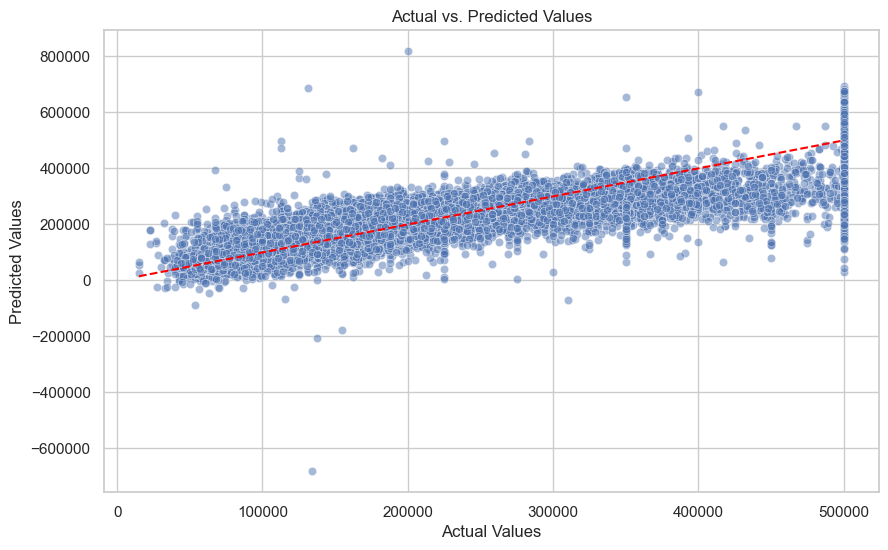

In [320]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Make predictions on the full dataset
housing_predictions = lin_reg.predict(housing_prepared)

# Compute Mean Squared Error and Root Mean Squared Error
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)

# Print RMSE neatly
print(f"Root Mean Squared Error (RMSE): {lin_rmse:.2f}")

# Plot Actual vs. Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(housing_labels, housing_predictions, alpha=0.5, edgecolors="w", linewidth=0.5)
plt.plot([min(housing_labels), max(housing_labels)], [min(housing_labels), max(housing_labels)], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.grid(True)
plt.show()


# 🌳 Decision Tree Regressor

The Decision Tree Regressor is a versatile machine learning model that predicts a continuous target variable by learning simple decision rules inferred from the data features. It creates a tree-like model of decisions based on feature values.

In [275]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [322]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print(f'Tree RMSE: {tree_rmse}')

Tree RMSE: 0.0


If a model shows no errors, it likely overfits the data, so use part of the training set for validation to ensure it generalizes well before testing.


# 🔄 Cross-Validation

Cross-validation is a technique used to evaluate a model's performance and ensure it generalizes well to unseen data. It involves splitting the training data into multiple subsets, training the model on some subsets, and validating it on the remaining ones.

- Cross-Validation of Decision Tree Model
- Cross-Validation of Linear Regression Model


   Fold    RMSE Score
0     1  72782.805092
1     2  71629.376350
2     3  68185.215851
3     4  70828.788346
4     5  69431.809462
5     6  77219.699067
6     7  70728.967784
7     8  74070.557522
8     9  68445.542751
9    10  72567.316350

Mean RMSE: 71589.01
Standard Deviation: 2601.63


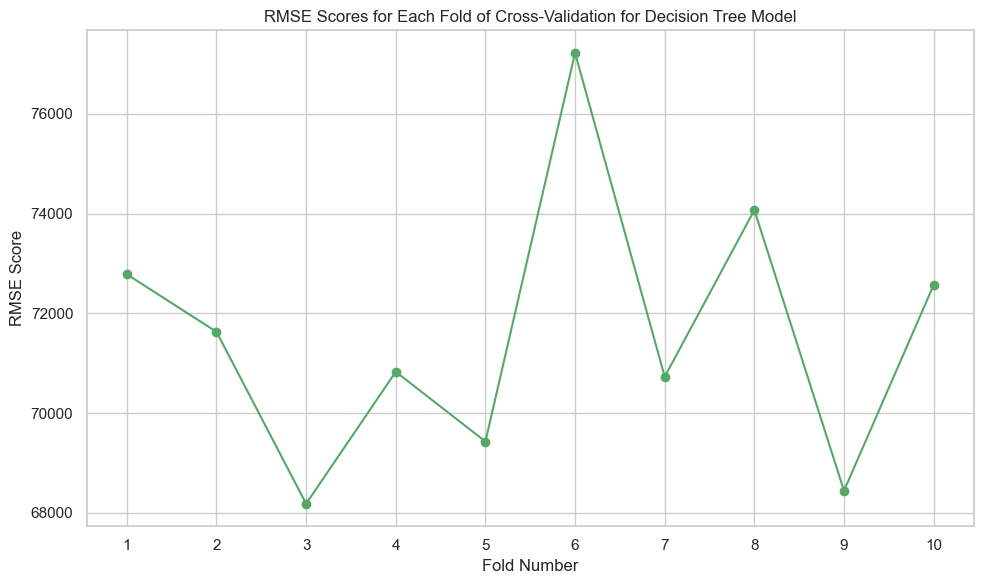

In [333]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score

# Perform cross-validation
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

# Create a DataFrame to display scores
scores_df = pd.DataFrame({
    'Fold': np.arange(1, len(tree_rmse_scores) + 1),
    'RMSE Score': tree_rmse_scores
})

# Add Mean and Standard Deviation
mean_rmse = tree_rmse_scores.mean()
std_rmse = tree_rmse_scores.std()

# Print the DataFrame
print(scores_df)
print(f"\nMean RMSE: {mean_rmse:.2f}")
print(f"Standard Deviation: {std_rmse:.2f}")

# Plot RMSE Scores
plt.figure(figsize=(10, 6))


plt.plot(np.arange(1, len(tree_rmse_scores) + 1), tree_rmse_scores, marker='o', linestyle='-', color='g')
plt.title('RMSE Scores for Each Fold of Cross-Validation for Decision Tree Model')
plt.xlabel('Fold Number')
plt.ylabel('RMSE Score')
plt.grid(True)
plt.xticks(np.arange(1, len(tree_rmse_scores) + 1))

plt.tight_layout()
plt.show()

In [324]:

# Perform cross-validation
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

# Create a DataFrame to display RMSE scores
lin_scores_df = pd.DataFrame({
    'Fold': np.arange(1, len(lin_rmse_scores) + 1),
    'RMSE Score': lin_rmse_scores
})

# Add Mean and Standard Deviation
mean_rmse = lin_rmse_scores.mean()
std_rmse = lin_rmse_scores.std()

# Print the DataFrame
print(lin_scores_df)
print(f"\nMean RMSE: {mean_rmse:.2f}")
print(f"Standard Deviation: {std_rmse:.2f}")



   Fold    RMSE Score
0     1  71762.763644
1     2  64114.991664
2     3  67771.171244
3     4  68635.190721
4     5  66846.140895
5     6  72528.037254
6     7  73997.080502
7     8  68802.336293
8     9  66443.288369
9    10  70139.799240

Mean RMSE: 69104.08
Standard Deviation: 2880.33


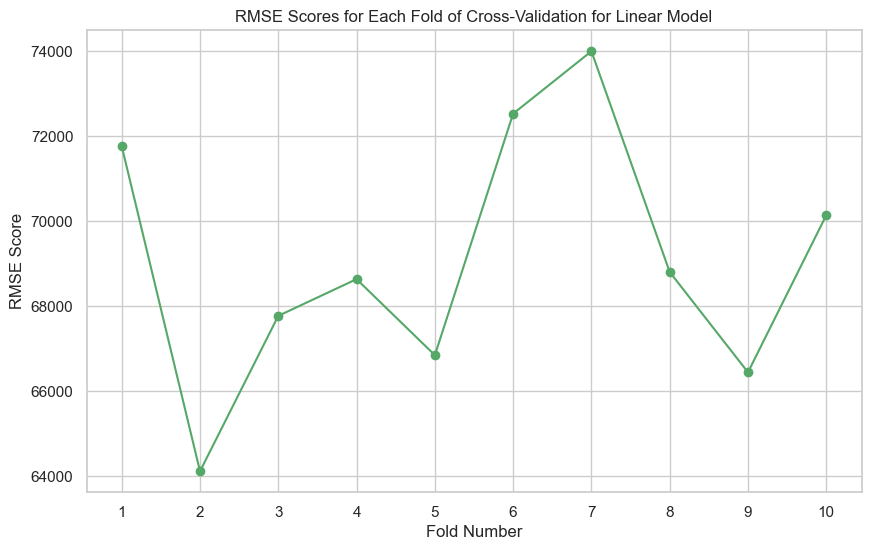

In [332]:
import matplotlib.pyplot as plt

# Create a line plot for RMSE scores
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(lin_rmse_scores) + 1), lin_rmse_scores, marker='o', linestyle='-', color='g')
plt.title('RMSE Scores for Each Fold of Cross-Validation for Linear Model')
plt.xlabel('Fold Number')
plt.ylabel('RMSE Score')
plt.grid(True)
plt.xticks(np.arange(1, len(lin_rmse_scores) + 1))
plt.show()

## Conclusion

The Decision Tree model is overfitting the training data significantly, leading to poorer performance compared to the Linear Regression model. This indicates that the Decision Tree model's predictions are highly specific to the training data and may not generalize well to unseen data.


## RandomForestRegressor

The RandomForestRegressor uses ensemble learning by training multiple Decision Trees on random subsets of features and averaging their predictions. This approach often improves performance by reducing overfitting and enhancing generalization. We’ll focus on this model next, with details similar to those used for other models.


In [334]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

# Train the model
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

# Predict on the training set
housing_predictions = forest_reg.predict(housing_prepared)

# Calculate RMSE on the training set
forest_rmse = np.sqrt(mean_squared_error(housing_labels, housing_predictions))

# Cross-validation to get a better sense of the model's performance
forest_rmse_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                     scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_rmse_scores)

# Create a DataFrame to display RMSE scores
scores_df = pd.DataFrame({
    'Fold': np.arange(1, len(forest_rmse_scores) + 1),
    'RMSE Score': forest_rmse_scores
})

# Add Mean and Standard Deviation
mean_rmse = forest_rmse_scores.mean()
std_rmse = forest_rmse_scores.std()

# Print the DataFrame
print(scores_df)
print(f"\nMean RMSE: {mean_rmse:.2f}")
print(f"Standard Deviation: {std_rmse:.2f}")


   Fold    RMSE Score
0     1  51658.382373
1     2  49108.300784
2     3  47100.165994
3     4  51976.618981
4     5  47171.985655
5     6  51931.503819
6     7  52442.090497
7     8  50151.025205
8     9  48636.240056
9    10  53650.221746

Mean RMSE: 50382.65
Standard Deviation: 2174.77


Random Forests show promise but still exhibit overfitting, with much lower training set scores compared to validation sets. To address overfitting, consider simplifying or regularizing the model, or acquiring more training data.


## Fine-Tuning Your Model 🔧

To optimize models, use **GridSearchCV** from Scikit-Learn to automate hyperparameter tuning. Instead of manually adjusting parameters, **GridSearchCV** evaluates all possible combinations of specified hyperparameters through cross-validation. This approach is more efficient and systematic for finding the best model settings. 🔍


In [335]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [336]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [337]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30)

In [338]:
cvres = grid_search.cv_results_

In [285]:
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63904.93987161871 {'max_features': 2, 'n_estimators': 3}
55204.04531473552 {'max_features': 2, 'n_estimators': 10}
52632.012971890996 {'max_features': 2, 'n_estimators': 30}
60522.993054517225 {'max_features': 4, 'n_estimators': 3}
52826.72341139466 {'max_features': 4, 'n_estimators': 10}
50537.197353267205 {'max_features': 4, 'n_estimators': 30}
59716.26463447361 {'max_features': 6, 'n_estimators': 3}
51985.85610876729 {'max_features': 6, 'n_estimators': 10}
50157.4487061755 {'max_features': 6, 'n_estimators': 30}
58905.04456036575 {'max_features': 8, 'n_estimators': 3}
52291.30084320869 {'max_features': 8, 'n_estimators': 10}
50118.584790641034 {'max_features': 8, 'n_estimators': 30}
62095.580748803055 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54400.69305853586 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60647.91964205098 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52232.80402565548 {'bootstrap': False, 'max_features': 3, 'n_estimators'

**RandomizedSearchCV** is ideal for large hyperparameter spaces as it evaluates a fixed number of random combinations, offering efficiency and potentially finding good results faster than exhaustive grid search. 🌟


In [340]:
feature_importances = grid_search.best_estimator_.feature_importances_
print(f'Important Features: {feature_importances}')

Important Features: [6.77477594e-02 6.15431185e-02 4.15861428e-02 1.53245188e-02
 1.50314434e-02 1.55418263e-02 1.49458259e-02 3.86890118e-01
 5.22571334e-02 1.11175835e-01 5.21434090e-02 9.43365471e-03
 1.51747549e-01 3.70088980e-05 1.63901408e-03 2.95564200e-03]


In [341]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.38689011781053195, 'median_income'),
 (0.1517475494996733, 'INLAND'),
 (0.11117583549913324, 'pop_per_hhold'),
 (0.0677477594173887, 'longitude'),
 (0.06154311848671401, 'latitude'),
 (0.052257133403813744, 'rooms_per_hhold'),
 (0.052143408965499204, 'bedrooms_per_room'),
 (0.04158614277601196, 'housing_median_age'),
 (0.01554182634970638, 'population'),
 (0.015324518799357976, 'total_rooms'),
 (0.015031443374650599, 'total_bedrooms'),
 (0.014945825928162747, 'households'),
 (0.009433654709399357, '<1H OCEAN'),
 (0.0029556420004249926, 'NEAR OCEAN'),
 (0.0016390140815729236, 'NEAR BAY'),
 (3.70088979589555e-05, 'ISLAND')]

After fine-tuning your models, evaluate the final model on the test set by using the `transform()` method of your pipeline to prepare the data, then assess performance using the test set's predictors and labels. 🔍


Final Model RMSE: 47720.35


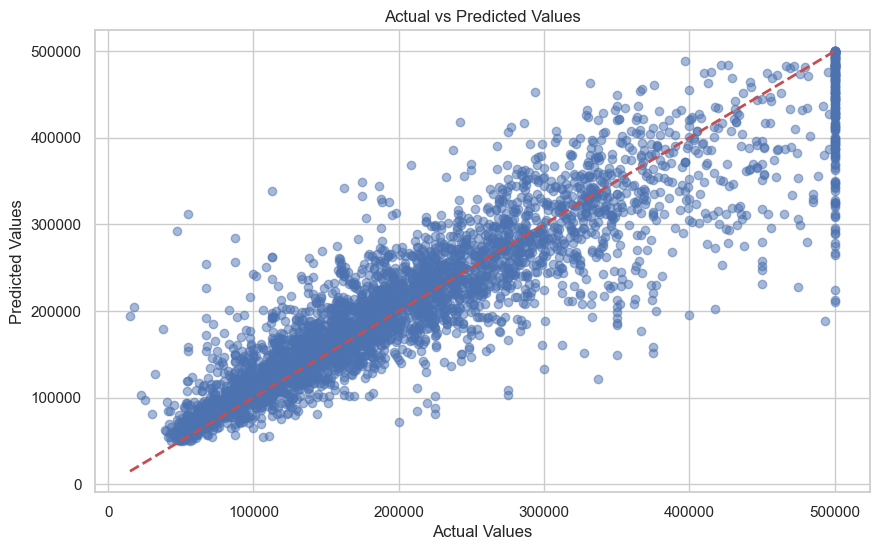

In [342]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Assuming `grid_search` is already defined and fitted
final_model = grid_search.best_estimator_

# Prepare the test set
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)

# Make predictions and evaluate the model
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

# Print the important outputs
print(f"Final Model RMSE: {final_rmse:.2f}")

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, final_predictions, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Diagonal line
plt.grid(True)
plt.show()


### Evaluating the Final Model

After evaluating the final model on the test set with an RMSE of 47,730.2, it's crucial to assess the precision of this estimate. To achieve this, compute a 95% confidence interval for the generalization error. This interval provides a range in which the true error is likely to fall, offering a better sense of how reliable the RMSE estimate is.


In [343]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([45730.68209016, 49630.32139364])

### Confidence Interval for Generalization Error

The resulting confidence interval is approximately [45,685.10, 49,691.25], indicating the range within which the true RMSE is expected to lie with 95% confidence. This helps in understanding the variability and reliability of the model’s performance.
